In [1]:
import uproot
import awkward as ak

import numpy as np
import pickle
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math
import xmltodict
import json


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from LearningCutsUtils.ScanNetwork import ScanNetwork
from LearningCutsUtils.LossFunctions import full_loss_fn

In [2]:
campaigns=["mc23a",
           "mc23d",
           "mc23e"]

targeteffics=[0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,0.98,0.99]
conv_type=["unconverted"]
eta_bins=["0.0","0.6"]
loose_pt_bins=[7,10,15,20,25,30,35,40,50,1000] # only needed for loose tuning
pt_bins=[7,10,15,20,25,30,35,40,45,50,60,80,100,125,150,175,500,1000] # good for medium and tight
mu_bins=[0,60] #20,30,40,50,60]
branches = ['y_pt_custom','y_eta_custom','y_Rhad','y_Rhad1','y_Reta','y_Rphi','y_weta2','y_Eratio','y_deltae','y_wtots1','y_fracs1','y_weta1','evt_mu']
training_branches = ['y_Rhad','y_Reta','y_Rphi','y_weta2','y_Eratio','y_deltae','y_wtots1','y_fracs1','y_weta1']

training_branches_latex = ['$R_{{had}}$','$R_{{\\eta}}$','$R_{{\\phi}}$',
                           '$w_{{\\eta,2}}$','$E_{{ratio}}$','$\\Delta E [MeV]$',
                           '$w^{{tot}}_{{\\eta 1}}$','$F_{{side}}$','$w_{{\\eta^{{3}}_{{\\eta 1}}}}$']

In [3]:
# don't do the last pT bin, not worth it
N_pt_bins=len(pt_bins)-2
N_mu_bins=len(mu_bins)-1

In [4]:
m=9
gt=1.
lt=-1.
cuts_gt_lt = [lt, gt, gt, lt, gt, ### change these to correct cuts
              lt, lt, lt, lt] # l g g l g l l l l 

In [5]:
arrays={}

for sb in ["sgn","bkg"]:
    arrays[sb]={}
    
    for conv in conv_type:
        arrays[sb][conv]={}
    
        for eta_i in range(len(eta_bins)-1):
            eta=eta_bins[eta_i]
            arrays[sb][conv][eta]={}
            
            for pt_i in range(len(pt_bins)-1):
                pt=pt_bins[pt_i]
                arrays[sb][conv][eta][pt]={}

                filetype="incl_ph"
                if pt<25:
                    filetype="rad_Z"
                
                tmpdata=[]
                for campaign in campaigns:
                    filespath=f"/data/ealmazan/optimised_files/results/{campaign}/{filetype}_{conv}/root_files/"
                    filename=f"{sb}_{conv}_{pt_bins[pt_i]}{pt_bins[pt_i+1]}_{eta_bins[eta_i]}{eta_bins[eta_i+1]}_160.root"
                    with uproot.open(filespath+filename) as infile:
                        tmpdata.append(infile["SinglePhoton"].arrays(branches))
                
                cat=ak.concatenate(tmpdata)
                
                for mu_i in range(len(mu_bins)-1):
                    mu = mu_bins[mu_i]
                    mumask=((cat['evt_mu'] > mu_bins[mu_i]) & (cat['evt_mu'] < mu_bins[mu_i+1]))
                    
                    arrays[sb][conv][eta][pt][mu] = ak.drop_none(ak.mask(cat, mumask))

In [6]:
for pt in pt_bins[:-1]:
    for mu in mu_bins[:-1]:
        print(f"pt={pt:5d}, mu={mu:3d}: N_sig = {len(arrays["sgn"]["unconverted"]["0.0"][pt][mu]['y_eta_custom']):8d}, N_bkg = {len(arrays["bkg"]["unconverted"]["0.0"][pt][mu]['y_eta_custom']):8d}")

pt=    7, mu=  0: N_sig =   235228, N_bkg =   102062
pt=   10, mu=  0: N_sig =   416322, N_bkg =    23564
pt=   15, mu=  0: N_sig =   333702, N_bkg =     3066
pt=   20, mu=  0: N_sig =   261250, N_bkg =      713
pt=   25, mu=  0: N_sig =   868577, N_bkg =   187840
pt=   30, mu=  0: N_sig =   667939, N_bkg =    99759
pt=   35, mu=  0: N_sig =  2377399, N_bkg =    78602
pt=   40, mu=  0: N_sig =  1775590, N_bkg =    50780
pt=   45, mu=  0: N_sig =  1302166, N_bkg =    36907
pt=   50, mu=  0: N_sig =  3711716, N_bkg =    60122
pt=   60, mu=  0: N_sig =  4353884, N_bkg =    42144
pt=   80, mu=  0: N_sig =  2300358, N_bkg =    11172
pt=  100, mu=  0: N_sig =  1237459, N_bkg =     4503
pt=  125, mu=  0: N_sig =  1421326, N_bkg =     1557
pt=  150, mu=  0: N_sig =  1762949, N_bkg =      568
pt=  175, mu=  0: N_sig =  9388599, N_bkg =      644
pt=  500, mu=  0: N_sig = 11850630, N_bkg =        8


In [7]:
tensors={
    "x_train": {},
    "y_train": {},
    "x_test":  {},
    "y_test":  {},
    "scaler":  {},
}

tensorkeys=list(tensors.keys())

# this really slows things down
make_test_sample=False

# debug printouts
tensorize_debug=False

In [8]:
# Library expects pT and mu bins specified as indices, not values, while `arrays` stores as values.
# also pT binning is different for tight vs loose.
for conv in conv_type:
    for tk in tensorkeys: tensors[tk][conv]={}

    for eta_i in range(len(eta_bins)-1):
        eta=eta_bins[eta_i]
        for tk in tensorkeys: tensors[tk][conv][eta]={}
        
        for pt_i in range(N_pt_bins): 
            pt=pt_bins[pt_i]
            for tk in tensorkeys: tensors[tk][conv][eta][pt_i]={}

            for mu_i in range(N_mu_bins):
                mu=mu_bins[mu_i]

                sig_events=len(arrays["sgn"][conv][eta][pt][mu]["evt_mu"])
                bkg_events=len(arrays["bkg"][conv][eta][pt][mu]["evt_mu"])
                num_to_keep=min(sig_events,bkg_events)
                
                print(f"Starting pT={pt:4d}, mu={mu:3d} with {sig_events:8d} signal events and {bkg_events:8d} background events, only keeping {num_to_keep:6d} of each")
                
                # use same scaler for signal and background
                sc = StandardScaler()

                x=np.concatenate([np.column_stack([arrays["sgn"][conv][eta][pt][mu][f] for f in training_branches])[:num_to_keep],
                                  np.column_stack([arrays["bkg"][conv][eta][pt][mu][f] for f in training_branches])[:num_to_keep]])
                y=np.concatenate([np.ones(len(arrays["sgn"][conv][eta][pt][mu][:num_to_keep])),
                                  np.zeros(len(arrays["bkg"][conv][eta][pt][mu][:num_to_keep]))])    

                x_train = x
                y_train = y
                x_test = None
                y_test = None

                if tensorize_debug: print("... x and y ready")                
                
                if make_test_sample:
                    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
                    if tensorize_debug: print("... train_test_split done")

                x_train_scaled = sc.fit_transform(x_train)
                if make_test_sample:
                    x_test_scaled = sc.transform(x_test)

                if tensorize_debug: print("... scaling done")
                
                tensors["scaler" ][conv][eta][pt_i][mu_i] = sc
                tensors["x_train"][conv][eta][pt_i][mu_i] = torch.tensor(x_train_scaled,dtype=torch.float)
                tensors["y_train"][conv][eta][pt_i][mu_i] = torch.tensor(y_train       ,dtype=torch.float)

                if make_test_sample:
                    tensors["x_test" ][conv][eta][pt_i][mu_i] = torch.tensor(x_test_scaled ,dtype=torch.float)
                    tensors["y_test" ][conv][eta][pt_i][mu_i] = torch.tensor(y_test        ,dtype=torch.float)
                    
                if tensorize_debug: print("... tensorizing done")

Starting pT=   7, mu=  0 with   235228 signal events and   102062 background events, only keeping 102062 of each
Starting pT=  10, mu=  0 with   416322 signal events and    23564 background events, only keeping  23564 of each
Starting pT=  15, mu=  0 with   333702 signal events and     3066 background events, only keeping   3066 of each
Starting pT=  20, mu=  0 with   261250 signal events and      713 background events, only keeping    713 of each
Starting pT=  25, mu=  0 with   868577 signal events and   187840 background events, only keeping 187840 of each
Starting pT=  30, mu=  0 with   667939 signal events and    99759 background events, only keeping  99759 of each
Starting pT=  35, mu=  0 with  2377399 signal events and    78602 background events, only keeping  78602 of each
Starting pT=  40, mu=  0 with  1775590 signal events and    50780 background events, only keeping  50780 of each
Starting pT=  45, mu=  0 with  1302166 signal events and    36907 background events, only keepin

In [9]:
# some hyperparameters
activation_input_scale_factor=15
learning_rate=0.15
epochs=200
alpha=15.   # scaling factor to tune how important hitting the target signal efficiency is
beta=1e-1     # scaling factor to tune how important background rejection is
gamma=1e-5  # scaling factor for how aggressively to push the cuts to zero
delta=0.
epsilon=1e-1  # how much to penalize deviations

In [10]:
pt_ranges=[(pt_bins[i],pt_bins[i+1]) for i in range(N_pt_bins)] # don't do last pT bin, not enough bkg stats
mu_ranges=[(mu_bins[i],mu_bins[i+1]) for i in range(N_mu_bins)]
conv="unconverted"
eta="0.0"

Great.  Now for each (pT, mu) combo, get the ROC curve from applying the tuned cuts at different efficiency targets, and compare with 
the results from Earl's cuts, extracted from JSON files.

In [11]:
def pass_cuts(inp,mincuts):

    # Create masks for lower and upper bounds
    mask = torch.all(torch.Tensor(inp) > torch.Tensor(cuts_gt_lt)*torch.Tensor(mincuts),dim=1)

    return mask

earlcuts={}
for cuttype in ["new","newunsmth","smooth"]:
    for WP in ["tight","medium"]:
        for campaign in ["mc23d"]:
            fname=f"/data/ealmazan/plots/photon_id_plotting/silo_{WP}_{campaign}/{WP}_{cuttype}.json"
            print(fname)
            with open(fname,'r') as file:
                earlcuts[f"{WP}_{cuttype}_{campaign}"] = json.load(file)
 
key_map={
    "y_Rhad": "CutHadLeakage",
    "y_Reta": "Reta37",
    "y_Rphi": "Rphi33",
    "y_weta2": "weta2",
    "y_deltae": "deltae",
    "y_Eratio": "DEmaxs1",
    "y_wtots1": "wtot",
    "y_fracs1": "fracm",
    "y_weta1": "w1"
}

def tmvacutname(branchname,conv):
    return f"{key_map[branchname]}_photons{'Converted' if conv != 'unconverted' else 'NonConverted'}"

def tmvaptname(pt_i):
    return f"pt_{pt_bins[pt_i]}.0_{pt_bins[pt_i+1]}.0"

def tmvaetaindex(eta):
    # probably needs to be fixed.
    return eta_bins.index(eta)
    
def gettmvacuts(conv,eta,pt_i,cuttype="new",WP="tight",campaign="mc23d"):
    tmvacuts=[]
    
    for varname_i in range(len(training_branches)):
        varname = training_branches[varname_i]
        ltgt = cuts_gt_lt[varname_i]
        cuts=earlcuts[f"{WP}_{cuttype}_{campaign}"]
        if tmvacutname(varname,conv) in cuts:
            tmvacuts.append(cuts[tmvacutname(varname,conv)][tmvaptname(pt_i)][tmvaetaindex(eta)])
        else:
            tmvacuts.append(-1*ltgt*999)
    return tmvacuts

/data/ealmazan/plots/photon_id_plotting/silo_tight_mc23d/tight_new.json
/data/ealmazan/plots/photon_id_plotting/silo_medium_mc23d/medium_new.json
/data/ealmazan/plots/photon_id_plotting/silo_tight_mc23d/tight_newunsmth.json
/data/ealmazan/plots/photon_id_plotting/silo_medium_mc23d/medium_newunsmth.json
/data/ealmazan/plots/photon_id_plotting/silo_tight_mc23d/tight_smooth.json
/data/ealmazan/plots/photon_id_plotting/silo_medium_mc23d/medium_smooth.json


In [12]:
net = ScanNetwork(m,
                  pt_ranges,
                  mu_ranges,
                  targeteffics,
                  cuts_gt_lt,
                  activation_input_scale_factor) # will take m inputs, return m*n_eff outputs
net.load_state_dict(torch.load('net_learningbiases_pttarget_trained.pth',weights_only=False))

<All keys matched successfully>

ROC curve is not monotonic for pt=35, mu=0
FPRs: [0.0, tensor(0.1154), tensor(0.1145), tensor(0.2095), tensor(0.2174), tensor(0.2756), tensor(0.3326), tensor(0.3997), tensor(0.4312), tensor(0.4428), tensor(0.4480), tensor(0.4531), 1.0]
TPRs: [0.0, tensor(0.3462), tensor(0.3449), tensor(0.5811), tensor(0.6010), tensor(0.7171), tensor(0.8091), tensor(0.8923), tensor(0.9185), tensor(0.9268), tensor(0.9310), tensor(0.9343), 1.0]
ROC curve is not monotonic for pt=40, mu=0
FPRs: [0.0, tensor(0.0943), tensor(0.1883), tensor(0.1631), tensor(0.2504), tensor(0.2793), tensor(0.3408), tensor(0.4083), tensor(0.4387), tensor(0.4495), tensor(0.4545), tensor(0.4589), 1.0]
TPRs: [0.0, tensor(0.2706), tensor(0.5096), tensor(0.4505), tensor(0.6504), tensor(0.7126), tensor(0.8149), tensor(0.8964), tensor(0.9223), tensor(0.9296), tensor(0.9328), tensor(0.9360), 1.0]
ROC curve is not monotonic for pt=45, mu=0
FPRs: [0.0, tensor(0.1235), tensor(0.0867), tensor(0.2282), tensor(0.2129), tensor(0.2773), tensor(

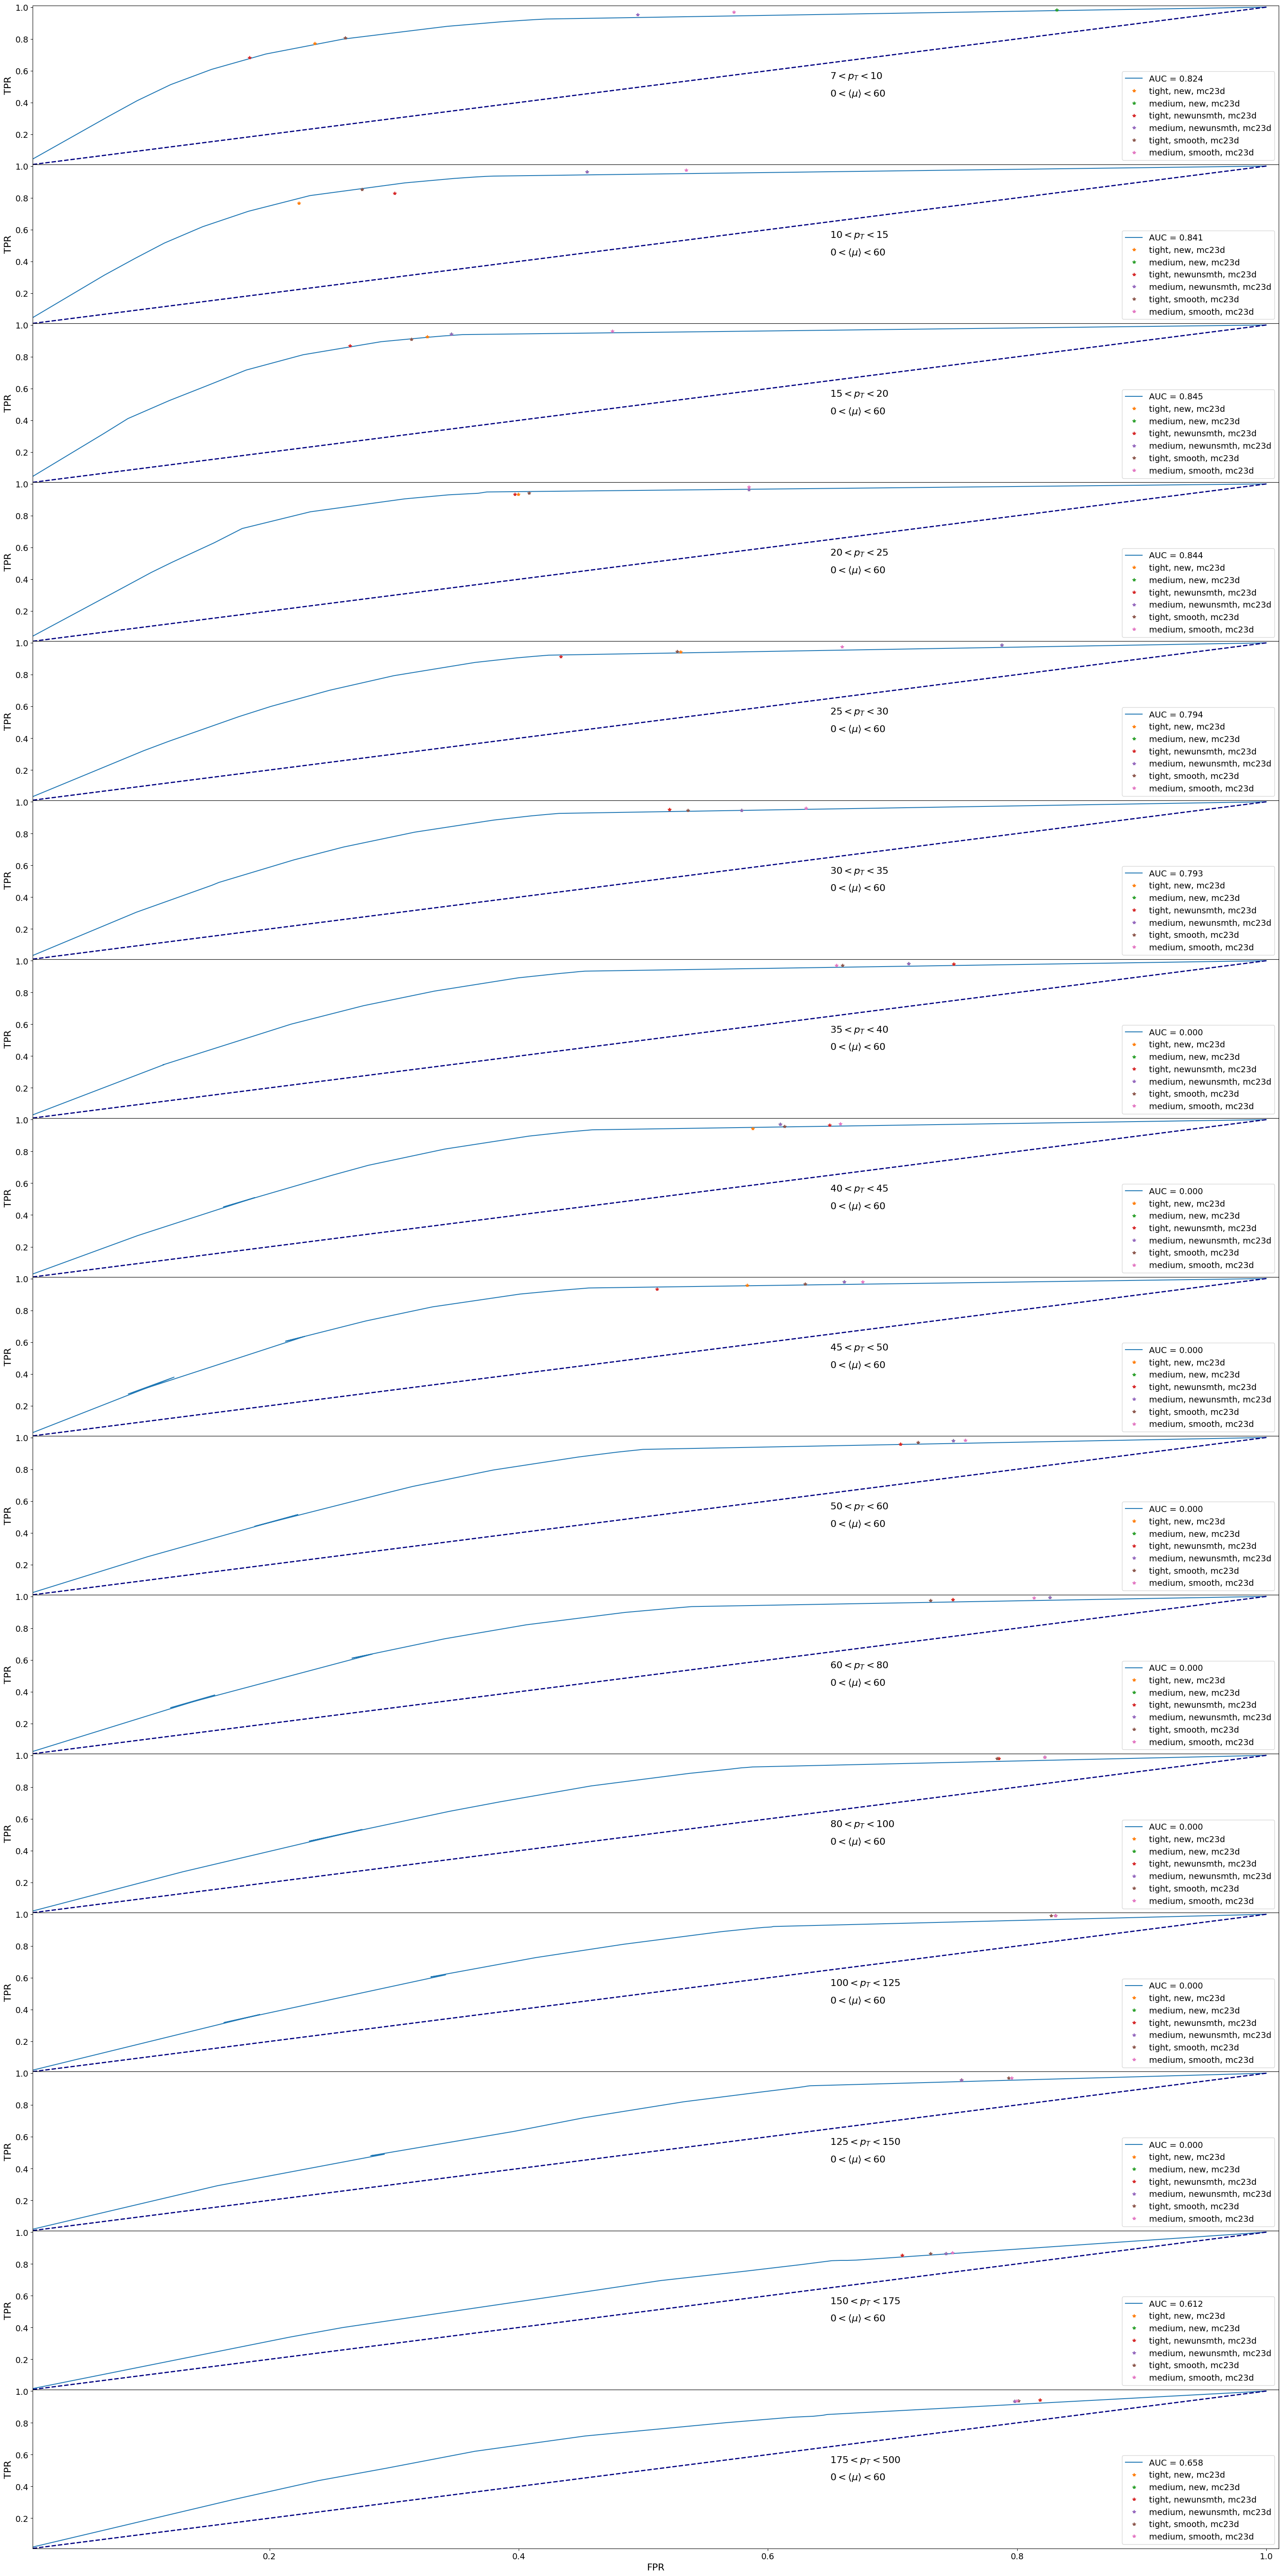

In [13]:
tprs={}
fprs={}

fig,axes=plt.subplots(nrows=N_pt_bins, ncols=N_mu_bins, figsize=(30,60))
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

for pt_i in range(N_pt_bins):
    pt=pt_bins[pt_i]
    tprs[pt]={}
    fprs[pt]={}

    tmvacutsets=[]
    tmvacutlabels=[]
    for cuttype in ["new","newunsmth","smooth"]:
        for WP in ["tight","medium"]:
            for campaign in ["mc23d"]:
                tmvacutsets.append(gettmvacuts(conv,eta,pt_i,cuttype,WP,campaign))
                tmvacutlabels.append(f"{WP}, {cuttype}, {campaign}")
    
    for mu_i in range(N_mu_bins):
        mu=mu_bins[mu_i]
        tprs[pt][mu]=[0.]
        fprs[pt][mu]=[0.]

        for n in range(len(targeteffics)):
            #if targeteffics[n]<0.2: continue
            #ax=fig.add_subplot(2,5,1+n-3)
            #plt.subplots_adjust(hspace=0.8,wspace=0.5)
            thisnet=net.nets[pt_i][mu_i][n]
            thisnet.eval()
            passcuts = thisnet.pass_cuts(tensors["x_train"][conv][eta][pt_i][mu_i])
            true_pos = torch.dot(passcuts.to(torch.int),tensors["y_train"][conv][eta][pt_i][mu_i].to(torch.int))
            fals_pos = torch.dot(passcuts.to(torch.int),(1.-tensors["y_train"][conv][eta][pt_i][mu_i]).to(torch.int))
        
            tprs[pt][mu].append(true_pos/torch.sum(tensors["y_train"][conv][eta][pt_i][mu_i]))
            fprs[pt][mu].append(fals_pos/torch.sum(1.-tensors["y_train"][conv][eta][pt_i][mu_i]))
        
        tprs[pt][mu].append(1.)
        fprs[pt][mu].append(1.)

        lw = 2

        thisauc=0.
        try:
            thisauc=auc(fprs[pt][mu],tprs[pt][mu])
        except(ValueError):
            thisauc=0.
            print(f"ROC curve is not monotonic for pt={pt}, mu={mu}")
            print(f"FPRs: {fprs[pt][mu]}")
            print(f"TPRs: {tprs[pt][mu]}")

        if N_mu_bins>1:
            plot=axes[pt_i,mu_i]
        else:
            plot=axes[pt_i]
            
        plot.plot(fprs[pt][mu], tprs[pt][mu], label=f"AUC = {thisauc:.3f}")

        for tmvacuts_i in range(len(tmvacutsets)):
            tmvacuts=tmvacutsets[tmvacuts_i]
            tmvalabel=tmvacutlabels[tmvacuts_i]
            passtmvacuts  = pass_cuts(tensors["scaler"][conv][eta][pt_i][mu_i].inverse_transform(tensors["x_train"][conv][eta][pt_i][mu_i]),
                                      tmvacuts)
            tmva_true_pos = torch.dot(passtmvacuts.to(torch.int),tensors["y_train"][conv][eta][pt_i][mu_i].to(torch.int))
            tmva_fals_pos = torch.dot(passtmvacuts.to(torch.int),(1.-tensors["y_train"][conv][eta][pt_i][mu_i]).to(torch.int))
        
            tprt = tmva_true_pos/torch.sum(tensors["y_train"][conv][eta][pt_i][mu_i])
            fprt = tmva_fals_pos/torch.sum(1.-tensors["y_train"][conv][eta][pt_i][mu_i])
            
            plot.plot(fprt, tprt, "*", label=tmvalabel)
        plot.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plot.text(0.65, 0.55, rf'${pt_bins[pt_i]}<p_T<{pt_bins[pt_i+1]}$', fontsize=16)
        plot.text(0.65, 0.44, rf'${mu_bins[mu_i]}<\langle\mu\rangle<{mu_bins[mu_i+1]}$', fontsize=16)
        plot.set_xlim([0.01, 1.01])
        plot.set_ylim([0.01, 1.01])
        
        if pt_i==(N_pt_bins-1):
            plot.set_xlabel('FPR')
        else:
            plot.tick_params(axis='x', labelsize=0)

        if mu_i==0:
            plot.set_ylabel('TPR')
        else:
            plot.tick_params(axis='y', labelsize=0)
            
        #plt.title('ROC curve')
        plot.legend(loc="lower right")

ROC curve is not monotonic for pt=35, mu=0
FPRs: [0.0, tensor(0.1154), tensor(0.1145), tensor(0.2095), tensor(0.2174), tensor(0.2756), tensor(0.3326), tensor(0.3997), tensor(0.4312), tensor(0.4428), tensor(0.4480), tensor(0.4531), 1.0]
TPRs: [0.0, tensor(0.3462), tensor(0.3449), tensor(0.5811), tensor(0.6010), tensor(0.7171), tensor(0.8091), tensor(0.8923), tensor(0.9185), tensor(0.9268), tensor(0.9310), tensor(0.9343), 1.0]
ROC curve is not monotonic for pt=40, mu=0
FPRs: [0.0, tensor(0.0943), tensor(0.1883), tensor(0.1631), tensor(0.2504), tensor(0.2793), tensor(0.3408), tensor(0.4083), tensor(0.4387), tensor(0.4495), tensor(0.4545), tensor(0.4589), 1.0]
TPRs: [0.0, tensor(0.2706), tensor(0.5096), tensor(0.4505), tensor(0.6504), tensor(0.7126), tensor(0.8149), tensor(0.8964), tensor(0.9223), tensor(0.9296), tensor(0.9328), tensor(0.9360), 1.0]
ROC curve is not monotonic for pt=45, mu=0
FPRs: [0.0, tensor(0.1235), tensor(0.0867), tensor(0.2282), tensor(0.2129), tensor(0.2773), tensor(

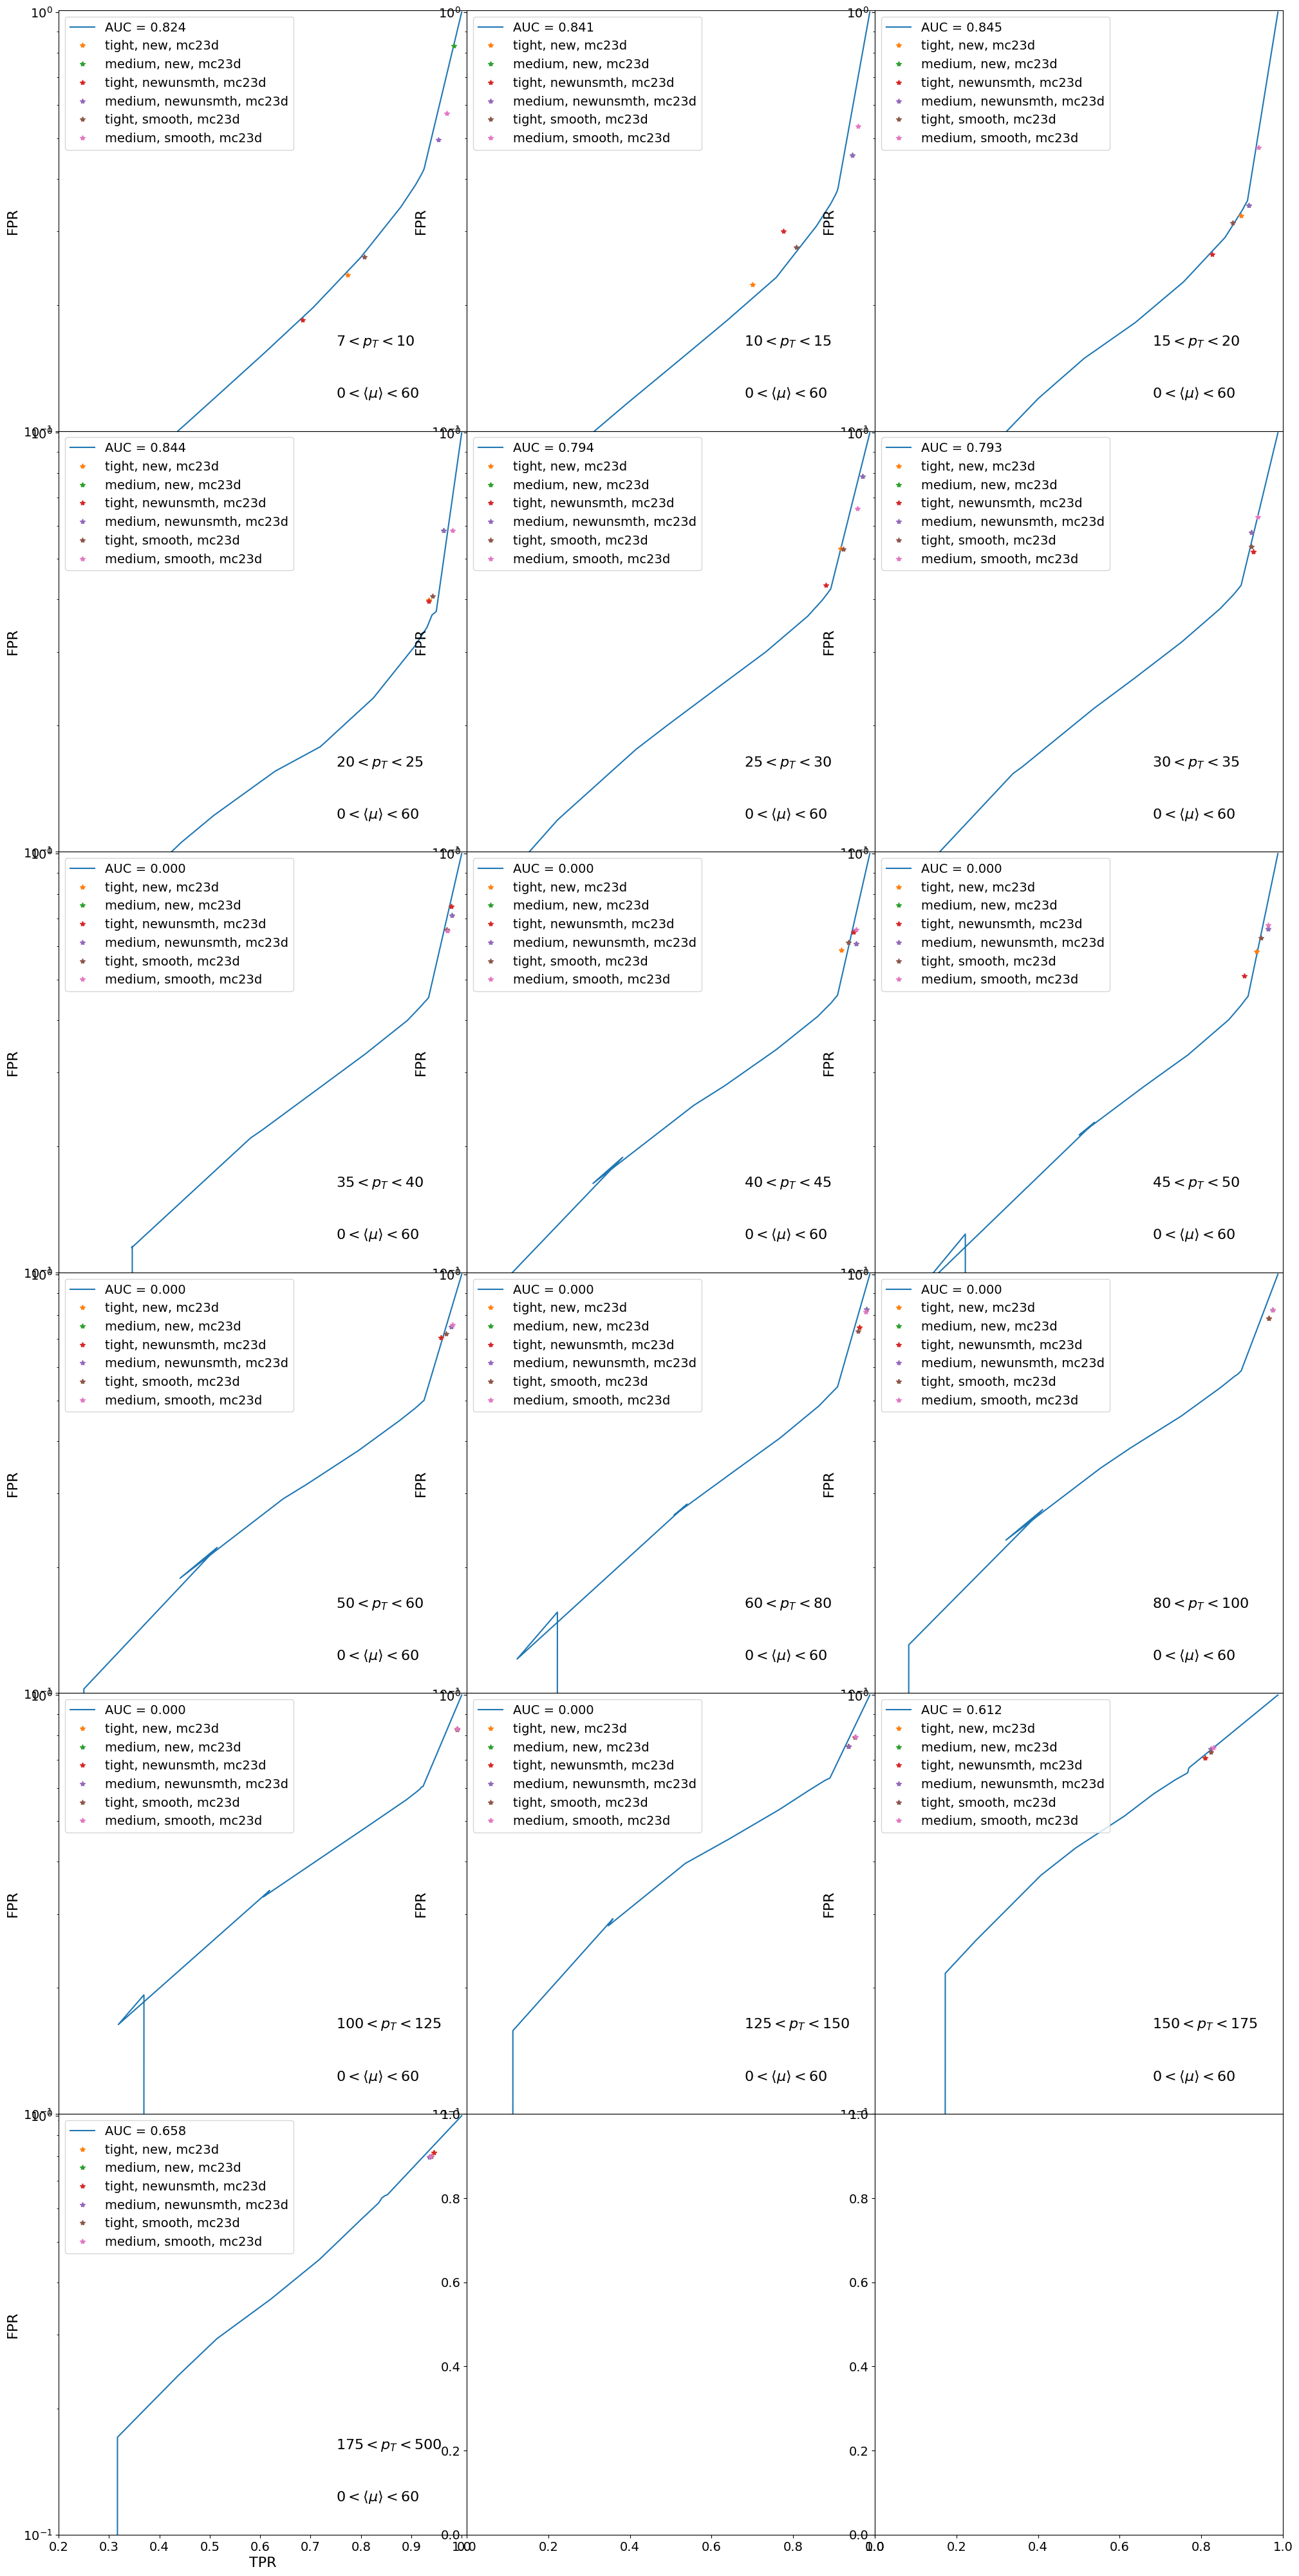

In [24]:
tprs={}
fprs={}
import math

if N_mu_bins<2:
    figsize=(20,40)
    fig,axes=plt.subplots(nrows=math.ceil(N_pt_bins/3), ncols=3, figsize=figsize)
else:
    figsize=(30,60)
    fig,axes=plt.subplots(nrows=N_pt_bins, ncols=N_mu_bins, figsize=figsize)
    
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

for pt_i in range(N_pt_bins):
    pt=pt_bins[pt_i]
    tprs[pt]={}
    fprs[pt]={}

    tmvacutsets=[]
    tmvacutlabels=[]
    for cuttype in ["new","newunsmth","smooth"]:
        for WP in ["tight","medium"]:
            for campaign in ["mc23d"]:
                tmvacutsets.append(gettmvacuts(conv,eta,pt_i,cuttype,WP,campaign))
                tmvacutlabels.append(f"{WP}, {cuttype}, {campaign}")
    
    for mu_i in range(N_mu_bins):
        mu=mu_bins[mu_i]
        tprs[pt][mu]=[0.]
        fprs[pt][mu]=[0.]

        for n in range(len(targeteffics)):
            #if targeteffics[n]<0.2: continue
            #ax=fig.add_subplot(2,5,1+n-3)
            #plt.subplots_adjust(hspace=0.8,wspace=0.5)
            thisnet=net.nets[pt_i][mu_i][n]
            thisnet.eval()
            passcuts = thisnet.pass_cuts(tensors["x_train"][conv][eta][pt_i][mu_i])
            true_pos = torch.dot(passcuts.to(torch.int),tensors["y_train"][conv][eta][pt_i][mu_i].to(torch.int))
            fals_pos = torch.dot(passcuts.to(torch.int),(1.-tensors["y_train"][conv][eta][pt_i][mu_i]).to(torch.int))
        
            tprs[pt][mu].append(true_pos/torch.sum(tensors["y_train"][conv][eta][pt_i][mu_i]))
            fprs[pt][mu].append(fals_pos/torch.sum(1.-tensors["y_train"][conv][eta][pt_i][mu_i]))
        
        tprs[pt][mu].append(1.)
        fprs[pt][mu].append(1.)

        lw = 2

        thisauc=0.
        try:
            thisauc=auc(fprs[pt][mu],tprs[pt][mu])
        except(ValueError):
            thisauc=0.
            print(f"ROC curve is not monotonic for pt={pt}, mu={mu}")
            print(f"FPRs: {fprs[pt][mu]}")
            print(f"TPRs: {tprs[pt][mu]}")

        if N_mu_bins>1:
            plot=axes[pt_i,mu_i]
        else:
            plot=axes[int(pt_i/3)][pt_i%3]
            
        plot.plot(tprs[pt][mu], fprs[pt][mu], label=f"AUC = {thisauc:.3f}")

        for tmvacuts_i in range(len(tmvacutsets)):
            tmvacuts=tmvacutsets[tmvacuts_i]
            tmvalabel=tmvacutlabels[tmvacuts_i]
            passtmvacuts = pass_cuts(tensors["scaler"][conv][eta][pt_i][mu_i].inverse_transform(tensors["x_train"][conv][eta][pt_i][mu_i]),
                                     tmvacuts)
            tmva_true_pos = torch.dot(passtmvacuts.to(torch.int),tensors["y_train"][conv][eta][pt_i][mu_i].to(torch.int))
            tmva_fals_pos = torch.dot(passtmvacuts.to(torch.int),(1.-tensors["y_train"][conv][eta][pt_i][mu_i]).to(torch.int))
        
            tprt = tmva_true_pos/torch.sum(tensors["y_train"][conv][eta][pt_i][mu_i])
            fprt = tmva_fals_pos/torch.sum(1.-tensors["y_train"][conv][eta][pt_i][mu_i])
            
            plot.plot(tprt, fprt, "*", label=tmvalabel)
        #plot.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plot.text(0.75, 0.16, rf'${pt_bins[pt_i]}<p_T<{pt_bins[pt_i+1]}$', fontsize=16)
        plot.text(0.75, 0.12, rf'${mu_bins[mu_i]}<\langle\mu\rangle<{mu_bins[mu_i+1]}$', fontsize=16)
        plot.set_xlim([0.2, 1.01])
        plot.set_ylim([0.1, 1.01])
        plot.set_yscale('log')
        
        if pt_i==(N_pt_bins-1):
            plot.set_xlabel('TPR')
        else:
            plot.tick_params(axis='x', labelsize=0)

        if mu_i==0:
            plot.set_ylabel('FPR')
        else:
            plot.tick_params(axis='y', labelsize=0)
            
        #plt.title('ROC curve')
        plot.legend(loc="upper left")

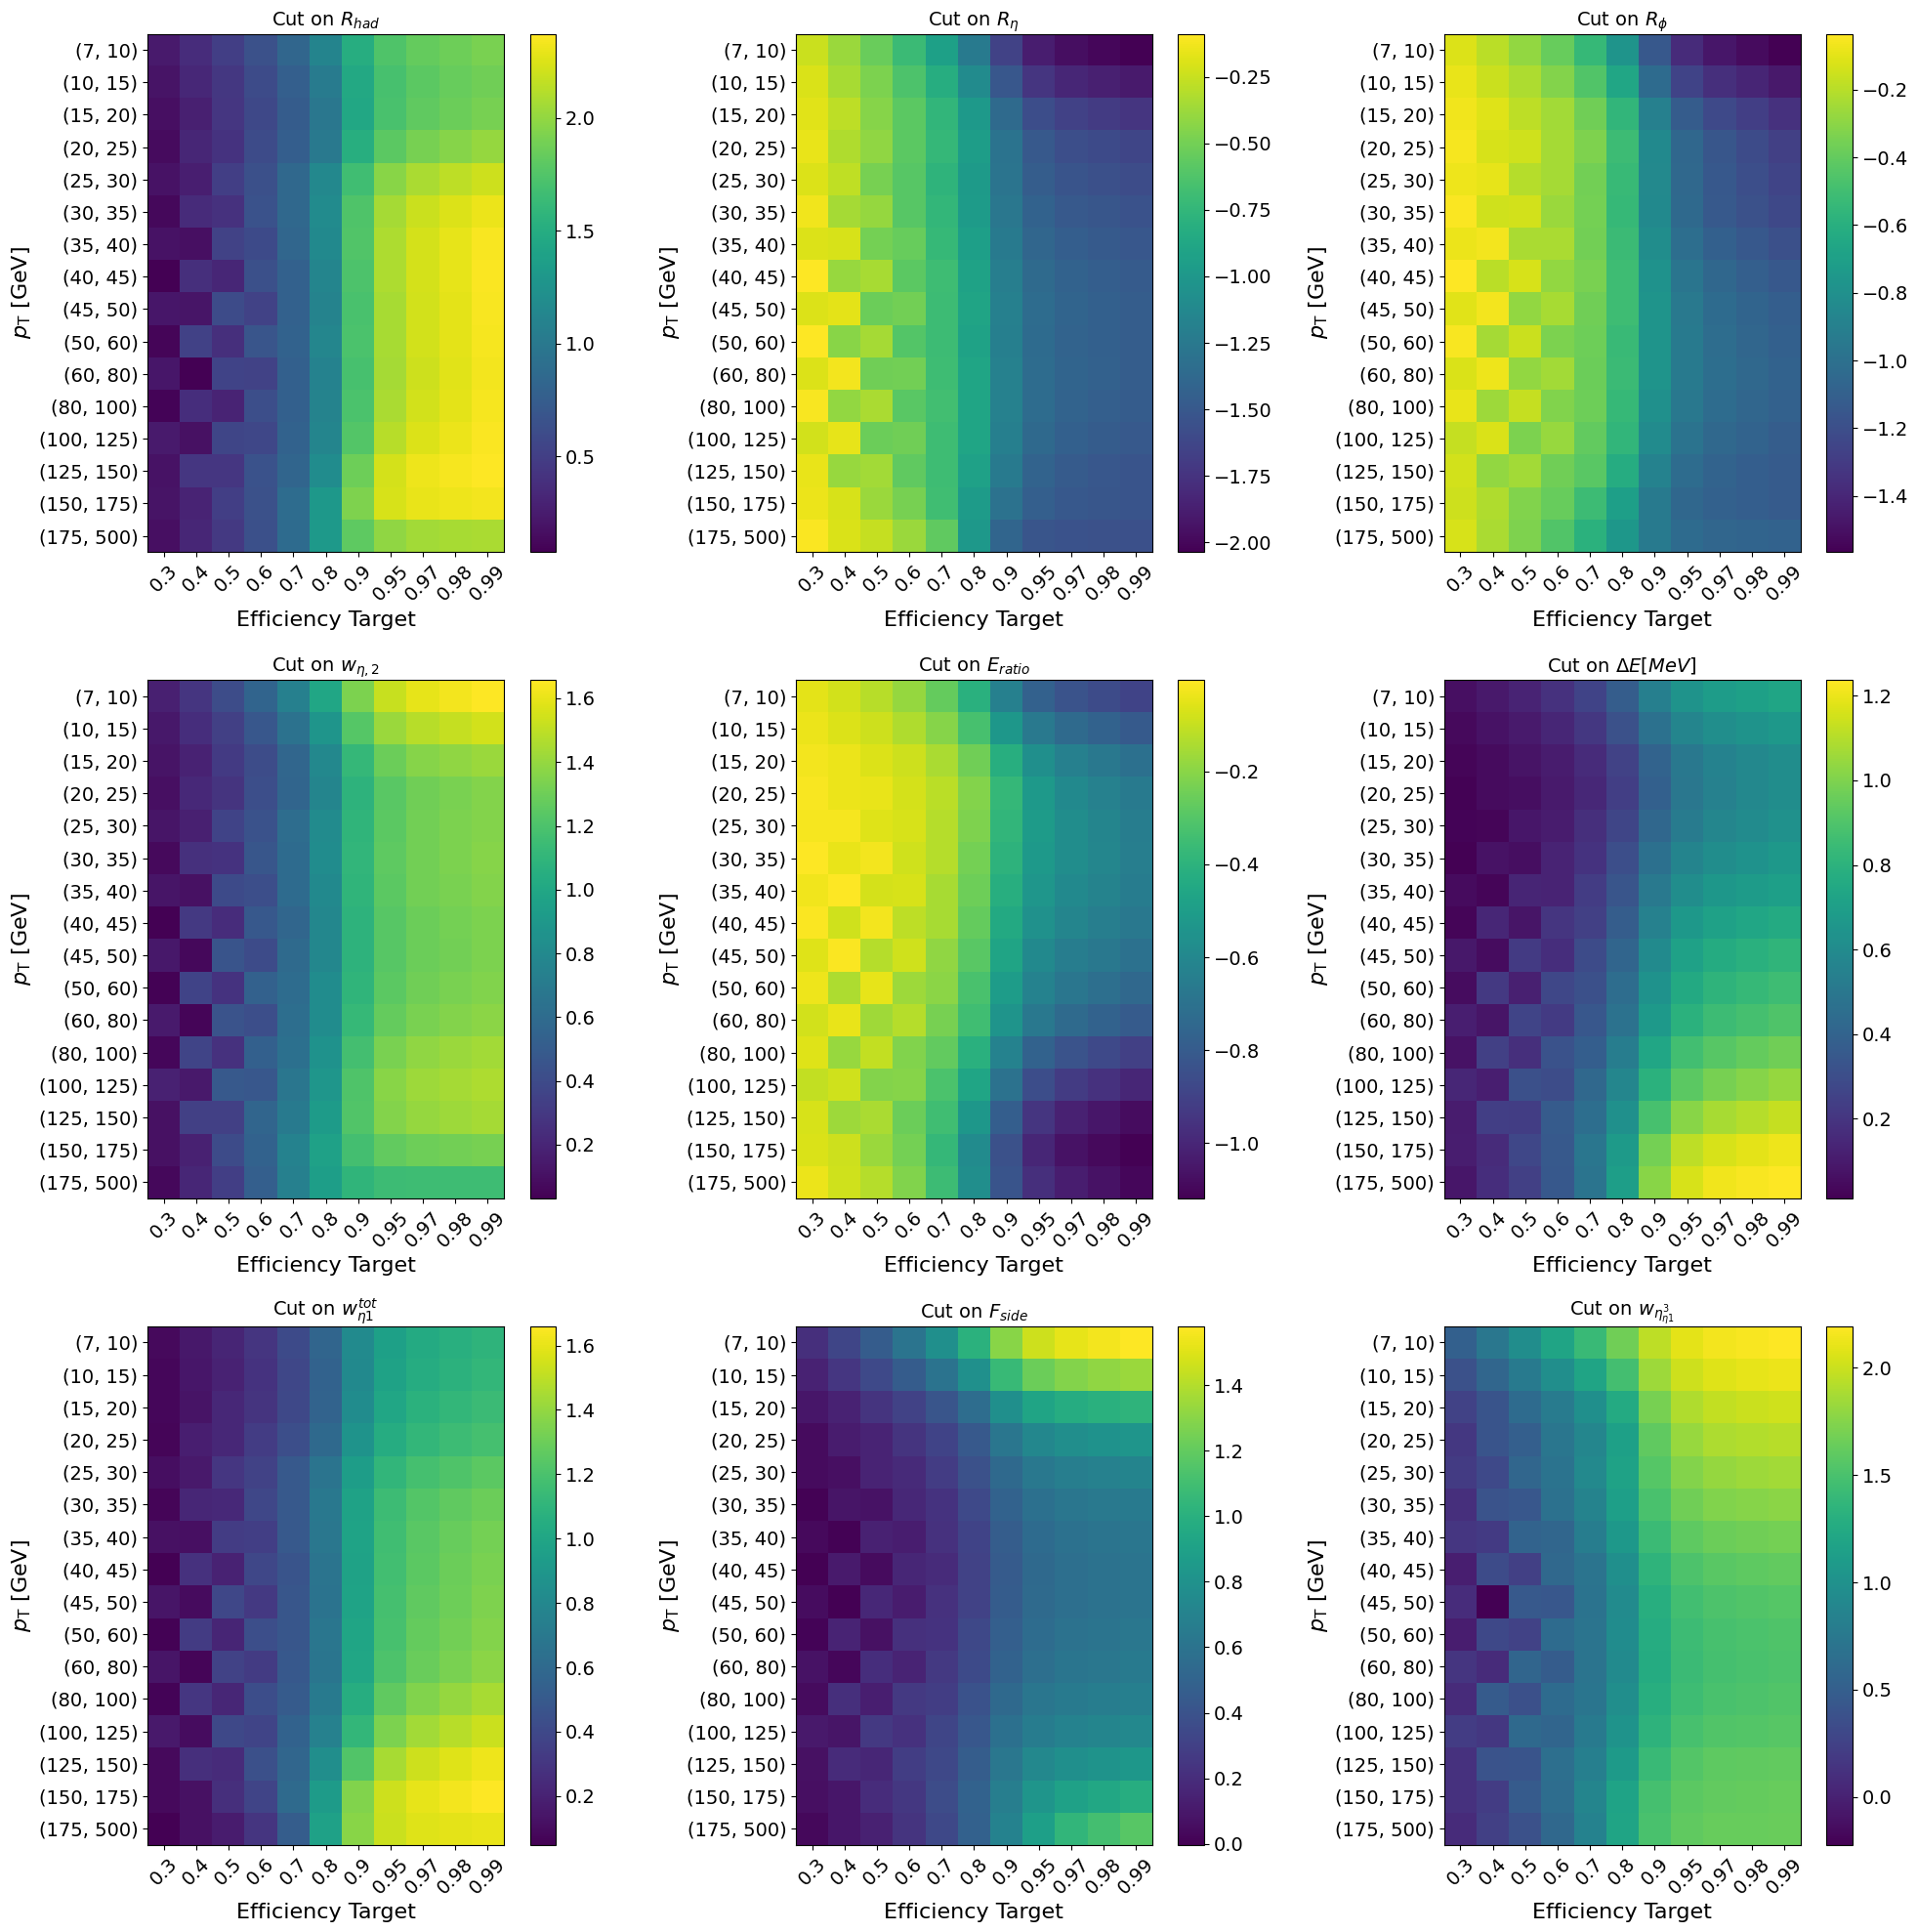

In [16]:
def cutsheatmap(net,g):
    targeteffics=net.effics
    pt=net.pt
    mu=net.mu
    m=net.features
    scaled_cuts=[[[[[0] for _ in range(len(targeteffics))] for _ in range (len(mu))] for _ in range(len(pt))] for i in range(m)]
    for i in range(len(pt)):
        for j in range(len(mu)):
            for k in range(len(targeteffics)):
                cuts=net.nets[i][j][k].get_cuts().detach().numpy()
                for f in range(m):
                    cutval=cuts[f]
                    scaled_cuts[f][i][j][k]=cutval


    figsize=(0,0)
    if g=="mu_eff": figsize=(20,9)
    if g=="pt_eff": figsize=(20,20)
    if g=="mu_pt":  figsize=(20,10)
    
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=figsize)

    for b, ax in enumerate(axs.flatten()):
        if g == "mu_eff":
            # for a slice at pT=15 GeV [bin 2]
            im = ax.imshow([[scaled_cuts[b][2][i][j] for j in range(len(targeteffics))] for i in range(len(mu))])
            ax.set_xlabel('Efficiency Target')
            ax.set_ylabel('$\\langle\\mu\\rangle$')
            ax.set_xticks(range(len(targeteffics)), labels=targeteffics, rotation = 45)
            ax.set_yticks(range(len(mu)), labels=mu)
        elif g == "pt_eff":
            # for a slice at mu=40 [bin 3]
            im = ax.imshow([[scaled_cuts[b][i][0][j] for j in range(len(targeteffics))] for i in range(len(pt))])
            ax.set_xlabel('Efficiency Target')
            ax.set_ylabel('$p_{\\mathrm{T}}$ [GeV]')
            ax.set_xticks(range(len(targeteffics)), labels=targeteffics, rotation = 45)
            ax.set_yticks(range(len(pt)), labels=pt)
        elif g == "mu_pt":
            # for a slice at 80% efficiency [bin 5]
            im = ax.imshow([[scaled_cuts[b][j][i][5] for j in range(len(pt))] for i in range(len(mu))])
            ax.set_ylabel('$\\langle\\mu\\rangle$')
            ax.set_xlabel('$p_{\\mathrm{T}}$ [GeV]')
            ax.set_yticks(range(len(mu)), labels=mu)
            ax.set_xticks(range(len(pt)), labels=pt, rotation = 45)
            
        cbar = plt.colorbar(im, ax=ax)
        ax.set_title(f"Cut on {training_branches_latex[b]}")
        #ax.set_ylabel('$p_{\\mathrm{T}} [GeV]$')
    plt.tight_layout()
    plt.show()


grids_to_make=["pt_eff"]
if N_mu_bins>1: grid_to_make += ["mu_eff","mu_pt"]

for g in grids_to_make:
    cutsheatmap(net,g)

The plots above are for a single bin in the third dimension.  What we really need is a way to see how monotonic all these trends are in each bin, not just what the cut values are.

Fortunately we've defined a measure of "monotonicity" in the smoothness loss function!  So one thing we can do is just look at the value of the smoothness loss for each bin.

In [17]:
from LearningCutsUtils.LossFunctions import smooth_loss_fn
def smoothnessheatmap(net,g):
    ef=net.effics
    pt=[net.pt[z][0] for z in range(len(net.pt))]
    mu=[net.mu[z][0] for z in range(len(net.mu))]
    m=net.features

    ptstring="$p_{\\mathrm{T}}$"

    figsize=(0,0)
    if g=="mu_eff": figsize=(20,9)
    if g=="pt_eff": figsize=(20,20)
    if g=="mu_pt":  figsize=(20,10)
    
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=figsize)

    for b, ax in enumerate(axs.flatten()):
        if g == "mu_eff":
            im = ax.imshow([[smooth_loss_fn(pt, torch.Tensor([net.nets[i][j][k].get_cuts().detach().numpy()[b] for i in range(len(pt))])) for k in range(len(ef))] for j in range(len(mu))])
            ax.set_xlabel('Efficiency Target')
            ax.set_ylabel('$\\langle\\mu\\rangle$')
            ax.set_xticks(range(len(targeteffics)), labels=targeteffics, rotation = 45)
            ax.set_yticks(range(len(mu)), labels=mu)
            ax.set_title(f"Smoothness of cut on {training_branches_latex[b]} vs {ptstring}")
        elif g == "pt_eff":
            im = ax.imshow([[smooth_loss_fn(mu, torch.Tensor([net.nets[i][j][k].get_cuts().detach().numpy()[b] for j in range(len(mu))])) for k in range(len(ef))] for i in range(len(pt))])
            ax.set_xlabel('Efficiency Target')
            ax.set_ylabel(f'{ptstring} [GeV]')
            ax.set_xticks(range(len(targeteffics)), labels=targeteffics, rotation = 45)
            ax.set_yticks(range(len(pt)), labels=pt)
            ax.set_title(f"Smoothness of cut on {training_branches_latex[b]} vs $\\langle\\mu\\rangle$")
        elif g == "mu_pt":
            im = ax.imshow([[smooth_loss_fn(ef, torch.Tensor([net.nets[i][j][k].get_cuts().detach().numpy()[b] for k in range(len(ef))])) for i in range(len(pt))] for j in range(len(mu))])
            ax.set_ylabel('$\\langle\\mu\\rangle$')
            ax.set_xlabel(f'{ptstring} [GeV]')
            ax.set_yticks(range(len(mu)), labels=mu)
            ax.set_xticks(range(len(pt)), labels=pt, rotation = 45)
            ax.set_title(f"Smoothness of cut on {training_branches_latex[b]} vs Target Efficiency")
            
        cbar = plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# this doesn't make sense for just pT binning, we can draw the trends directly
if N_mu_bins>1: 
    for g in ["pt_eff","mu_eff","mu_pt"]:
        smoothnessheatmap(net,g)

In [18]:
def inspectonecut(net,b,pt_val,mu_val,ef_val):
    ef=net.effics
    pt=[net.pt[z][0] for z in range(len(net.pt))]
    mu=[net.mu[z][0] for z in range(len(net.mu))]

    if ef_val in ef:
        ef_i=ef.index(ef_val)
    elif ef_val/100 in ef:
        ef_i=ef.index(ef_val/100.)
    pt_i=pt.index(pt_val)
    mu_i=mu.index(mu_val)
    
    m=net.features

    ptstring="$p_{\\mathrm{T}}$"

    figsize=(20,5)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    # vs pT
    axs[0].plot(pt,[net.nets[i][mu_i][ef_i].get_cuts().detach().numpy()[b] for i in range(len(pt))])
    axs[0].set_xlabel(f'{ptstring} [GeV]')
    axs[0].set_ylabel(f'Cut on {training_branche_latex[b]}')
    

    # vs mu
    axs[1].plot(mu,[net.nets[pt_i][j][ef_i].get_cuts().detach().numpy()[b] for j in range(len(mu))])
    axs[1].set_xlabel('$\\langle\\mu\\rangle$')
    axs[1].set_ylabel(f'Cut on {training_branches_latex[b]}')

    # vs ef
    axs[2].plot(ef,[net.nets[pt_i][mu_i][k].get_cuts().detach().numpy()[b] for k in range(len(ef))])
    axs[2].set_xlabel('Efficiency Target')
    axs[2].set_ylabel(f'Cut on {training_branches_latex[b]}')
                
    plt.tight_layout()
    plt.show()

if N_mu_bins>1: 
    inspectonecut(net,3,20,30,50)


In [19]:
if N_mu_bins>1: 
    inspectonecut(net,3,20,20,30)

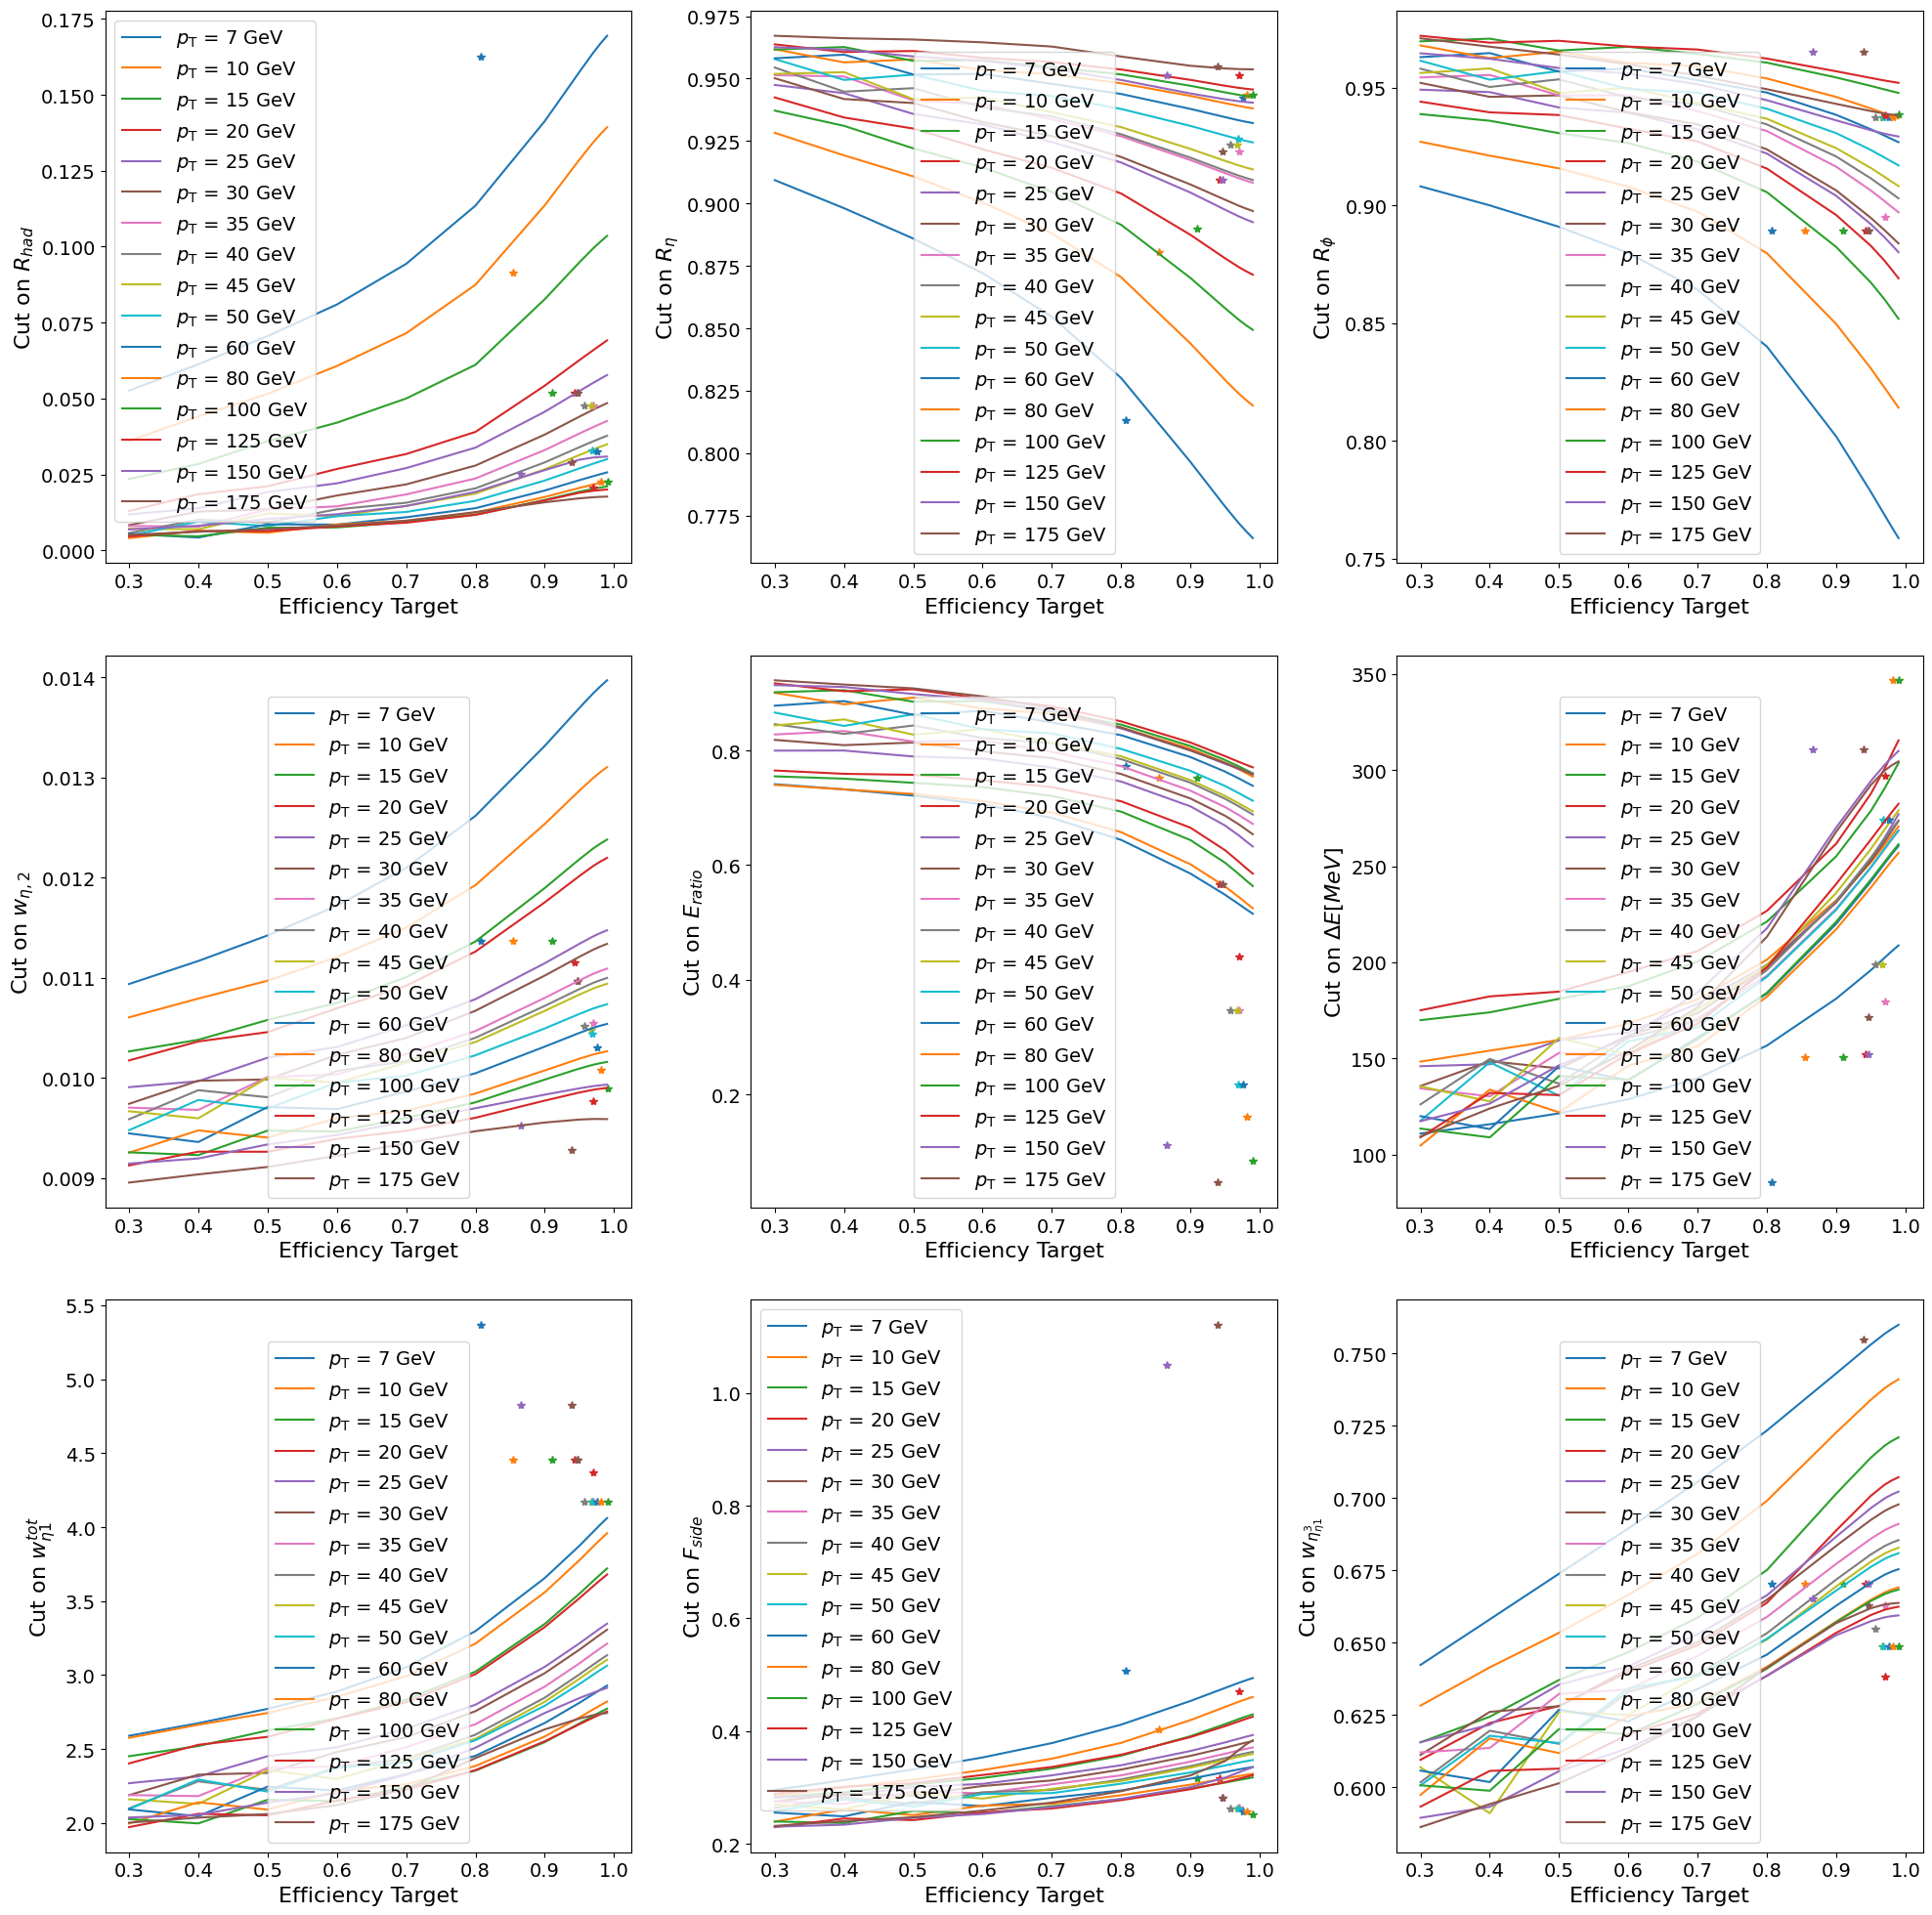

In [20]:
def cutspteff(net):
    targeteffics=net.effics
    pt=net.pt
    mu=net.mu
    m=net.features
    scaled_cuts=[[[[[0] for _ in range(len(targeteffics))] for _ in range (len(mu))] for _ in range(len(pt))] for i in range(m)]
    uscaled_cuts=[[[[[0] for _ in range(len(targeteffics))] for _ in range (len(mu))] for _ in range(len(pt))] for i in range(m)]
    for i in range(len(pt)):
        for j in range(len(mu)):
            for k in range(len(targeteffics)):
                cuts=net.nets[i][j][k].get_cuts().detach().numpy()
                uscuts=tensors["scaler"][conv][eta][i][0].inverse_transform([cuts])[0]
                for f in range(m):
                    scaled_cuts[f][i][j][k]=cuts[f]
                    uscaled_cuts[f][i][j][k]=uscuts[f]
    
    ptstring="$p_{\\mathrm{T}}$"

    figsize=(20,20)
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=figsize)

    for b, ax in enumerate(axs.flatten()):
        for p in range(len(pt)):
            cabincuts=[uscaled_cuts[b][p][0][k] for k in range(len(targeteffics))]
            tmvacuts=gettmvacuts(conv,eta,p,cuttype="smooth",WP="tight",campaign="mc23d")

            passtmvacuts = pass_cuts(tensors["scaler"][conv][eta][p][0].inverse_transform(tensors["x_train"][conv][eta][p][0]),
                                     tmvacuts)
            tmva_true_pos = torch.dot(passtmvacuts.to(torch.int),tensors["y_train"][conv][eta][p][0].to(torch.int))
            tprt = tmva_true_pos/torch.sum(tensors["y_train"][conv][eta][p][0])

            ax.plot(targeteffics,cabincuts,label=f"{ptstring} = {pt[p][0]} GeV")
            
            most_recent_line_color = ax.lines[-1].get_color()
            ax.plot(tprt, tmvacuts[b],"*",color=most_recent_line_color)
        ax.set_xlabel('Efficiency Target')
        ax.set_ylabel(f"Cut on {training_branches_latex[b]}")
        ax.legend()
        
    plt.tight_layout()
    plt.show()


cutspteff(net)

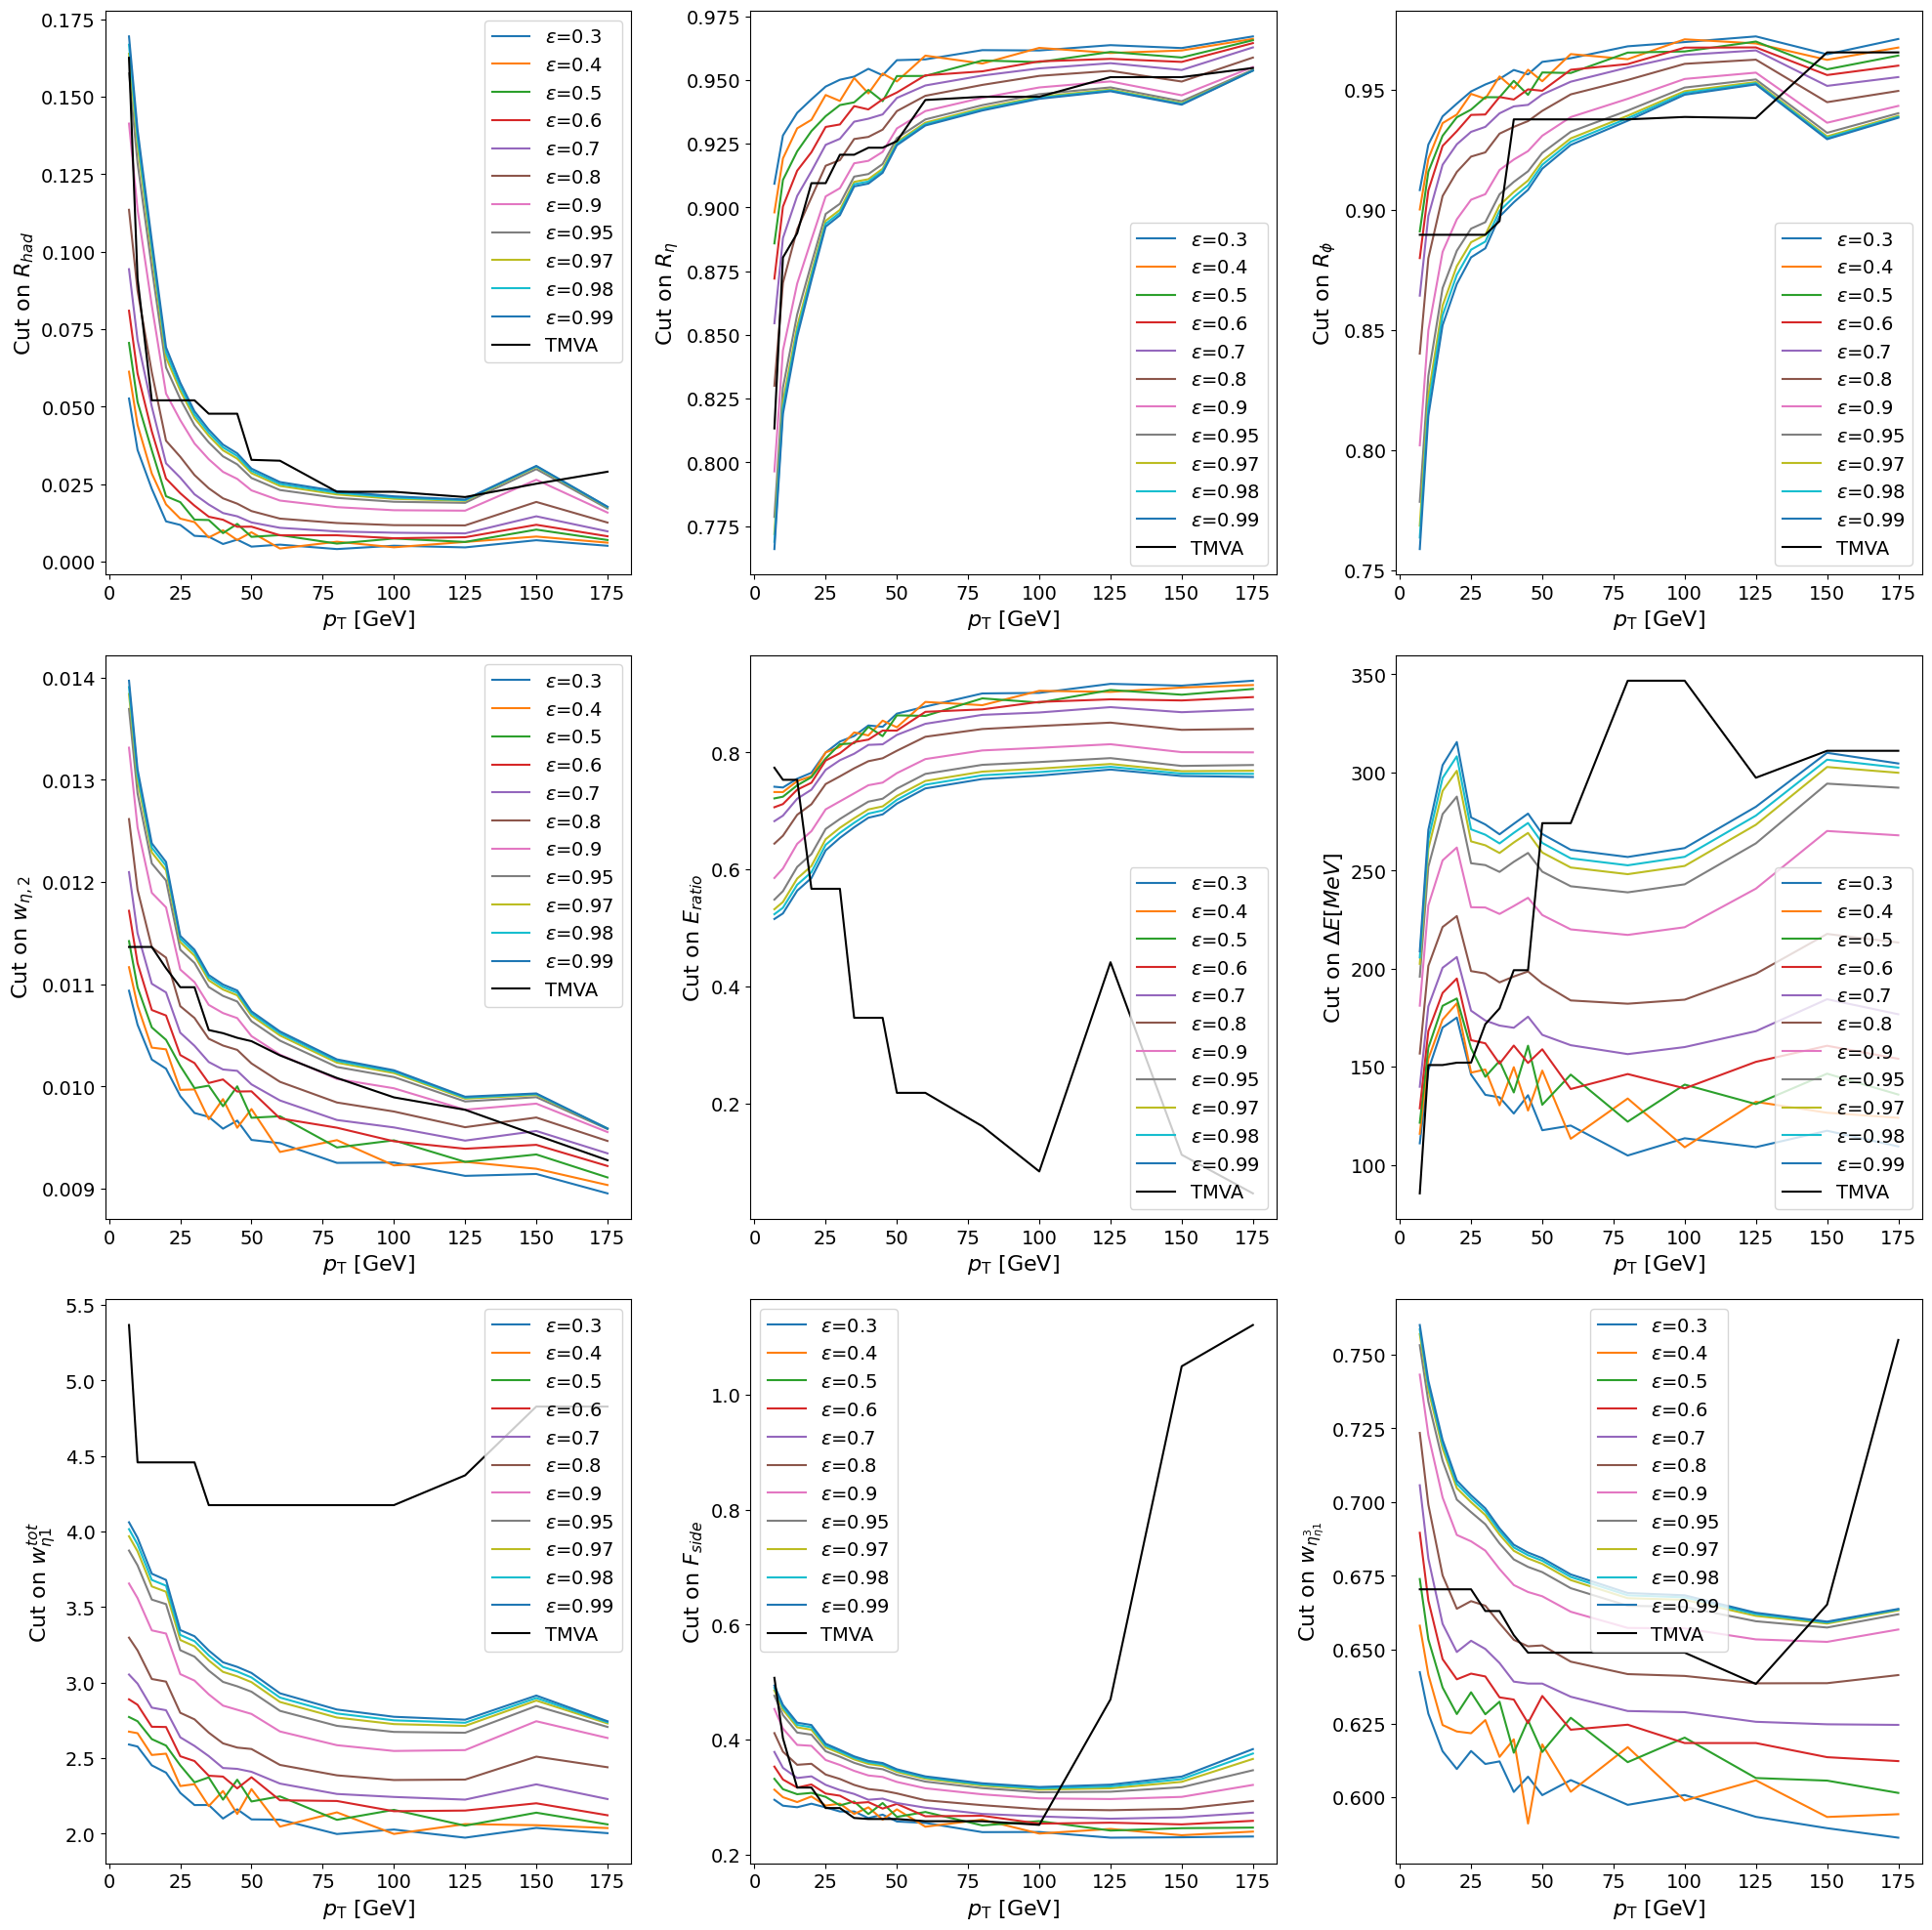

In [21]:
def cutseffpt(net):
    targeteffics=net.effics
    pt=net.pt
    mu=net.mu
    m=net.features
    scaled_cuts=[[[[[0] for _ in range(len(targeteffics))] for _ in range (len(mu))] for _ in range(len(pt))] for i in range(m)]
    uscaled_cuts=[[[[[0] for _ in range(len(targeteffics))] for _ in range (len(mu))] for _ in range(len(pt))] for i in range(m)]
    for i in range(len(pt)):
        for j in range(len(mu)):
            for k in range(len(targeteffics)):
                cuts=net.nets[i][j][k].get_cuts().detach().numpy()
                uscuts=tensors["scaler"][conv][eta][i][0].inverse_transform([cuts])[0]
                for f in range(m):
                    scaled_cuts[f][i][j][k]=cuts[f]
                    uscaled_cuts[f][i][j][k]=uscuts[f]

    figsize=(20,20)
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=figsize)

    for b, ax in enumerate(axs.flatten()):
        for k in range(len(targeteffics)):
            ax.plot([pt[p][0] for p in range(len(pt))],[uscaled_cuts[b][p][0][k] for p in range(len(pt))],label=f"$\\varepsilon$={targeteffics[k]}")
        
        tmvacuts=[gettmvacuts(conv,eta,p,cuttype="smooth",WP="tight",campaign="mc23d")[b] for p in range(len(pt))]
        ax.plot([pt[p][0] for p in range(len(pt))], tmvacuts,color='black',label="TMVA")

        
        ax.set_xlabel('$p_{\\mathrm{T}}$ [GeV]')
        ax.set_ylabel(f"Cut on {training_branches_latex[b]}")
        ax.legend()
    plt.tight_layout()
    plt.show()


cutseffpt(net)

Next steps:

* Check converted photons
* Check other eta bins